In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/')
from code_blocks.our_models.Multi_ISVGP import Multi_Variational_IGP
from run_experiments.prepare_dataset import *
from run_experiments.utils import helper_eval_multiIndepSVGP_model
import yaml
import torch
import numpy as np
from torch import Tensor
from utils_general import *

In [2]:
def load_model_and_likelihoods(multi_variational_igp, filename):
    state_dicts = torch.load(filename)
    for model, state_dict in zip(multi_variational_igp.models, state_dicts['models']):
        model.load_state_dict(state_dict)
    for likelihood, state_dict in zip(multi_variational_igp.likelihoods, state_dicts['likelihoods']):
        likelihood.load_state_dict(state_dict)
    
    return multi_variational_igp


In [3]:
torch.set_default_dtype(torch.float64)

## Load in model

In [4]:
config_file = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/configs/mocap_IGP/Scale_RBF/IndepSVGP_64_08.yaml'
model_and_likelihood_path = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/experiments_results/mocap_IGP/Scale_RBF/IndepSVGP_64_08/2024-03-05_13:45:36/MultiIGPs_models_and_likelihoods.pth'

In [5]:
with open(config_file, 'r') as file:
    config = yaml.safe_load(file)

MultiIGP = Multi_Variational_IGP(
        num_models = config['n_outputs'], 
        inducing_points = Tensor(np.linspace(config['init_inducing_input_LB'], config['init_inducing_input_UB'], config['n_inducing_input']).reshape(-1, 1)), 
        init_likelihood_noise = config['init_likelihood_noise'], 
        kernel_type = config['input_kernel_type'], 
        learn_inducing_locations= config['learn_inducing_locations_input'],
        input_dim = config['input_dim']
    )

MultiIGP = load_model_and_likelihoods(MultiIGP, model_and_likelihood_path)

## Load in data

In [6]:
if config['dataset_type'] == 'mocap':
    data_inputs, data_Y_squeezed, ls_of_ls_train_input, ls_of_ls_test_input, train_sample_idx_ls, test_sample_idx_ls, means, stds = prepare_mocap_data(config)

## Test

In [7]:
# The following piece of code copied from training_IGP.py file.
'''$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'''
# The following lists consist of datasets for all outputs.
list_train_X, list_train_Y = [], [] 
list_test_X, list_test_Y = [], []

# split data_Y_squeezed into train/test part. NOTE: that's train/test target data for all outputs.
data_Y_train_squeezed = data_Y_squeezed[train_sample_idx_ls]
data_Y_test_squeezed = data_Y_squeezed[test_sample_idx_ls]

n_input_test = config['n_input'] - config['n_input_train']
##### ------------------------------------------------------------------------
for i in range(config['n_outputs']):
    # start and end for current output, idx used to pick data for only current output
    idgp_train_start = i * config['n_input_train']
    idgp_train_end = idgp_train_start + config['n_input_train']

    idgp_test_start = i * n_input_test
    idgp_test_end = idgp_test_start + n_input_test

    # training data for current output
    train_X = data_inputs[ls_of_ls_train_input[i]]
    train_Y = data_Y_train_squeezed[idgp_train_start:idgp_train_end]
    assert train_X.shape ==  train_Y.shape == torch.Size([config['n_input_train']])
    list_train_X.append(train_X)
    list_train_Y.append(train_Y)

    # testing data for current output
    test_X = data_inputs[ls_of_ls_test_input[i]]
    test_Y = data_Y_test_squeezed[idgp_test_start:idgp_test_end]
    assert test_X.shape ==  test_Y.shape == torch.Size([n_input_test])
    list_test_X.append(test_X)
    list_test_Y.append(test_Y)
'''$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'''

'$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'

In [8]:
# for compute overall (all outputs) performance
train_error_square_sum = 0.
test_error_square_sum = 0.
train_error_length = 0.
test_error_length = 0.
train_nll_sum = 0.
test_nll_sum = 0.

# For visualization
n_points4visualization = 500
tensor_inputs4visualization = Tensor(np.linspace(config['min_input_bound'], config['max_input_bound'], n_points4visualization).reshape(-1, 1)) 
list_train_output_dist = []
list_test_output_dist = []
list_output_dist4visual = []

for j in range(config['n_outputs']):

    curr_model = MultiIGP.get_model(j)
    curr_likelihood = MultiIGP.get_likelihood(j)

    curr_model.eval()
    curr_likelihood.eval()
    
    # Inference for train and test data
    with torch.no_grad():
        curr_train_output_dist = curr_likelihood(curr_model(list_train_X[j]))
        curr_test_output_dist  = curr_likelihood(curr_model(list_test_X[j]))

    # Inference for data points for visualization
    visual_output_dist = curr_likelihood(curr_model(tensor_inputs4visualization))

    # store them for following visualization
    # list_train_output_dist.append(curr_train_output_dist)
    # list_test_output_dist.append(curr_test_output_dist)
    list_output_dist4visual.append(visual_output_dist)

    # playground
    

    # RMSE
    curr_train_suqare_errors = (curr_train_output_dist.loc.detach() - list_train_Y[j]).square()
    curr_test_square_errors = (curr_test_output_dist.loc.detach() - list_test_Y[j]).square()
    train_error_square_sum += curr_train_suqare_errors.sum()
    test_error_square_sum  += curr_test_square_errors.sum()
    print('-----' * 10)
    print(str(j) + 'th Model Train RMSE: ', curr_train_suqare_errors.mean().sqrt())
    print(str(j) + 'th Model Test RMSE: ', curr_test_square_errors.mean().sqrt())

    # NLL
    train_nll_ = neg_log_likelihood(list_train_Y[j], curr_train_output_dist.loc.detach(), curr_train_output_dist.variance.detach())
    test_nll_ = neg_log_likelihood(list_test_Y[j], curr_test_output_dist.loc.detach(), curr_test_output_dist.variance.detach())
    train_nll_sum += train_nll_ * len(list_train_Y[j])
    test_nll_sum  += test_nll_ *  len(list_test_Y[j])
    print(str(j) + 'th Model Train NLL: ', train_nll_)
    print(str(j) + 'th Model Test NLL: ', test_nll_)

    train_error_length += len(list_train_Y[j])
    test_error_length += len(list_test_Y[j])


print('#######' * 10)
print('Global Train RMSE', (train_error_square_sum / train_error_length).sqrt())
print('Global Test RMSE', (test_error_square_sum / test_error_length).sqrt())
print('Global Train NLL', train_nll_sum / train_error_length)
print('Global Test NLL', test_nll_sum / test_error_length)


--------------------------------------------------
0th Model Train RMSE:  tensor(0.1173)
0th Model Test RMSE:  tensor(1.0041)
0th Model Train NLL:  tensor(0.0393)
0th Model Test NLL:  tensor(1.2633)
--------------------------------------------------
1th Model Train RMSE:  tensor(0.6375)
1th Model Test RMSE:  tensor(8.2260)
1th Model Train NLL:  tensor(1.3096)
1th Model Test NLL:  tensor(52.0616)
--------------------------------------------------
2th Model Train RMSE:  tensor(0.1795)
2th Model Test RMSE:  tensor(0.5514)
2th Model Train NLL:  tensor(0.0555)
2th Model Test NLL:  tensor(0.8106)
--------------------------------------------------
3th Model Train RMSE:  tensor(0.2567)
3th Model Test RMSE:  tensor(3.1587)
3th Model Train NLL:  tensor(0.1442)
3th Model Test NLL:  tensor(7.7437)
--------------------------------------------------
4th Model Train RMSE:  tensor(0.2918)
4th Model Test RMSE:  tensor(0.6674)
4th Model Train NLL:  tensor(0.2384)
4th Model Test NLL:  tensor(0.9770)
----

## Plot

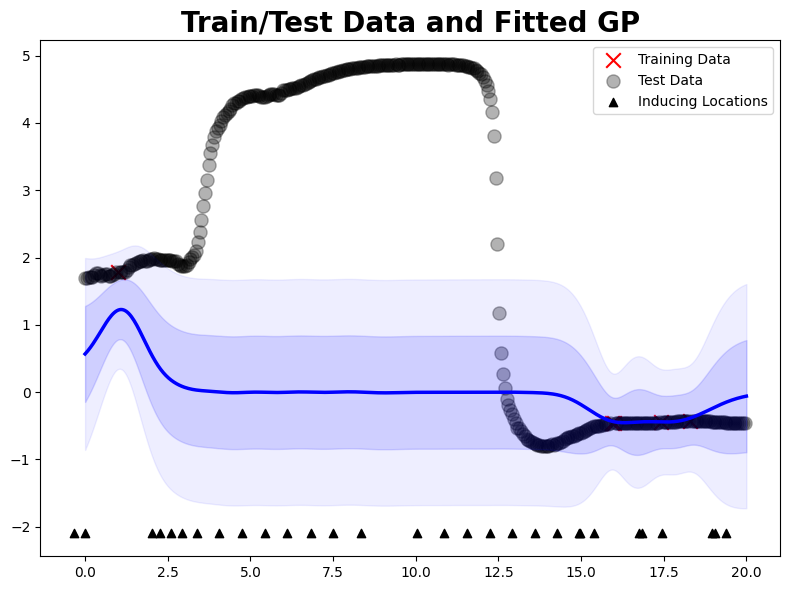

In [9]:
picked_index = 3 # 18

plot_traindata_testdata_fittedgp(train_X=list_train_X[picked_index], 
                                 train_Y=list_train_Y[picked_index], 
                                 test_X=list_test_X[picked_index], 
                                 test_Y=list_test_Y[picked_index], 
                                 gp_X=tensor_inputs4visualization, 
                                 gp_pred_mean=list_output_dist4visual[picked_index].loc.detach(), 
                                 gp_pred_std=list_output_dist4visual[picked_index].stddev.detach(), 
                                 inducing_points_X=MultiIGP.get_model(picked_index).variational_strategy.inducing_points.detach(), 
                                 n_inducing_C=config['n_inducing_input'], # NOTE: input is C not X
                                 # title='Independent SVGP, #18'
                                 ) 

# Test using function

In [10]:
norm_results_dict, origin_results_dict = helper_eval_multiIndepSVGP_model(
                                            multi_IndepSVGP=MultiIGP,
                                            data=[list_train_X, list_test_X, list_train_Y, list_test_Y],
                                            means=None,
                                            stds=None,
                                            config=config)

inputs tensor([13.6813, 18.0220,  7.0330,  8.1319,  4.6154])
preds tensor([ 0.0746,  1.0929, -0.7688, -0.8501,  0.2116])
var tensor([0.1615, 0.1658, 0.1572, 0.1600, 0.1730])


In [11]:
norm_results_dict

{'norm_train_rmse': tensor(0.2379),
 'norm_test_rmse': tensor(1.7916),
 'norm_train_nll': tensor(0.1567),
 'norm_test_nll': tensor(2.9672),
 'norm_train_nmse': tensor(0.0707),
 'norm_test_nmse': tensor(0.8935)}